# Stochastic Compute Metadata Summary

This is a proof of concept summary notebook, created using data from this stac [catalog](https://ffrd.cloud.dewberryanalytics.com/projects/kanawha/stac), to provide high level overview of the results from a stochastic compute.

---


## Storms Summary

The map below shows the storm centers for all events simulated. Smaller events generating < 1.0" of excess precipitation are shown in blue, and larger events are shown in red. Circles are also sized based on excess precipitation.

Hover over the points to get the date, and click on the point to see the execess precipitation for that event. Go to [stormviewer](https://storms.dewberryanalytics.com/) to get addtional information.

In [1]:
from pystac_client import Client
import pystac
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from notebook_utils import get_props, get_stats
import scrapbook as sb

api_url = "https://uampjfpbwi.us-east-1.awsapprunner.com/"
storm_items_collection_name = "kanawha-simulations-march-2024"


In [2]:
model_id = "BluestoneLocal"

In [3]:
client = Client.open(api_url)
collection = client.get_collection(storm_items_collection_name)
gdf = get_props(collection, model_id)

In [4]:

m = folium.Map(location=[gdf['latitude'].mean(), gdf['longitude'].mean()], zoom_start=7, tiles='OpenStreetMap',width='80%')

item = collection.get_item(f"{model_id}-0001")
folium.GeoJson(item.geometry, style_function=lambda x: {'fillColor': 'black', 'color': 'black'}).add_to(m)

for idx, row in gdf.iterrows():
    color = 'red' if row['precipitation_excess_inches'] > 1 else 'blue'  # Set the color to green if 'precip' is greater than 0.75, otherwise set it to black
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=row['precipitation_excess_inches'] + 2,  # Set the radius to the 'precip' property
                        popup=row['precipitation_excess_inches'],
                        tooltip=row['Historic_Storm_Date'],
                        fill=True,
                        fill_color=color,  # Set the fill color to blue
                        color=color  # Use the color variable to set the border color
                        ).add_to(m)

m



# Summary Statistics 

---

## Total Compute Time

Stats:


,Mean,Median,Min,Max
0,46.022333,45.858333,37.916667,53.566667


Histogram:


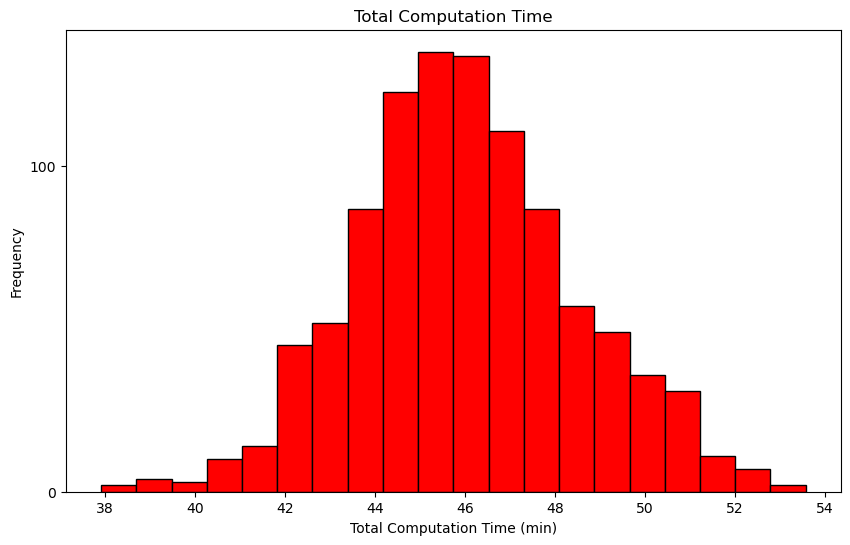

In [5]:

# Convert time column to total minutes (divide total seconds by 60)
gdf['computation_time_min'] = pd.to_timedelta(gdf['computation_time_total']).dt.total_seconds() / 60

plt.figure(figsize=(10, 6))
plt.hist(gdf['computation_time_min'], bins=20, color='red', edgecolor='black')
ymin, ymax = plt.ylim()

plt.ylim(ymin, np.ceil(ymax))

plt.yticks(np.arange(ymin, np.ceil(ymax)+1, 100))
plt.grid(False)

plt.xlabel('Total Computation Time (min)')
plt.ylabel('Frequency')
plt.title('Total Computation Time')

print("Stats:")
compute_time_stats = get_stats(gdf['computation_time_min'])
display(compute_time_stats)
print("Histogram:")
plt.show()

Note that the compute time may vary based on CPU used in cloud compute.

## Volume Error Summary

Stats:


,Mean,Median,Min,Max
0,7.859087,3.661412,0.020011,34.515835


Histogram:


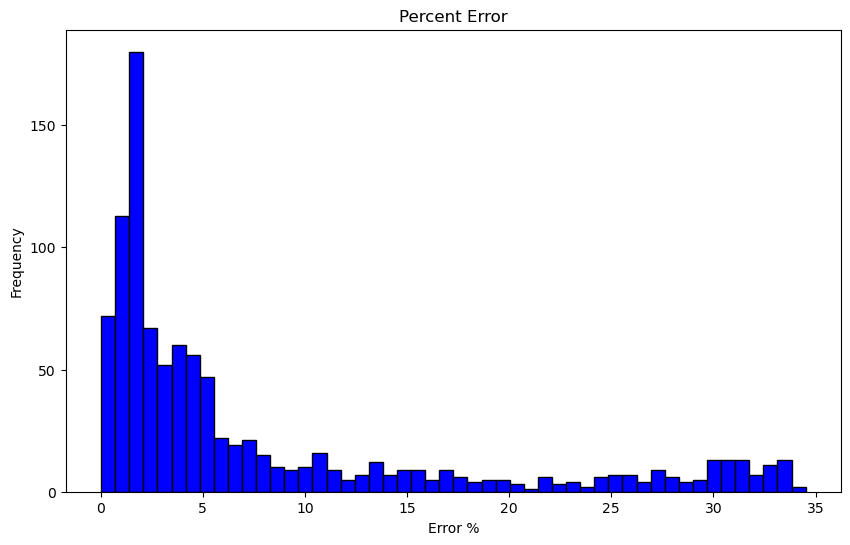

In [6]:
plt.figure(figsize=(10, 6))
gdf["error_percent"].plot(kind='hist', bins=50, color='blue', edgecolor='black')
plt.xlabel('Error %')
plt.ylabel('Frequency')
plt.title(f'Percent Error')

ymin, ymax = plt.ylim()

plt.ylim(ymin, np.ceil(ymax))

plt.yticks(np.arange(ymin, np.ceil(ymax)+1, 50))
plt.grid(False)

print("Stats:")
error_stats = get_stats(gdf["error_percent"])
display(error_stats)
print("Histogram:")
plt.show()

## Excess Precipitation Summary

Stats:


,Mean,Median,Min,Max
0,0.265549,0.106834,0.000002,5.430705


Histogram:


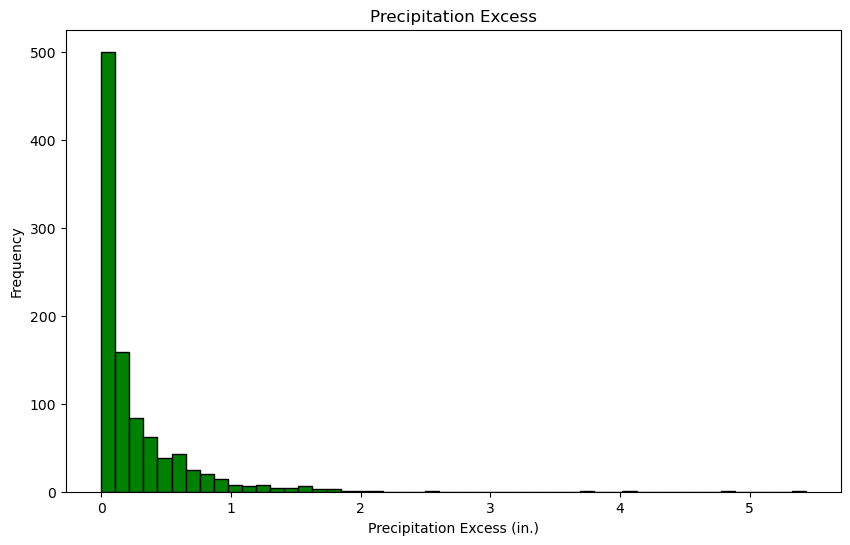

In [7]:
plt.figure(figsize=(10, 6))
gdf["precipitation_excess_inches"].plot(kind='hist', bins=50, color='green', edgecolor='black')

plt.xlabel('Precipitation Excess (in.)')
plt.ylabel('Frequency')
plt.title(f'Precipitation Excess')

ymin, ymax = plt.ylim()

plt.ylim(ymin, np.ceil(ymax))

plt.yticks(np.arange(ymin, np.ceil(ymax)+1, 100))

print("Stats:")
precip_stats = get_stats(gdf["precipitation_excess_inches"])
display(precip_stats)
print("Histogram:")
plt.show()

In [8]:
summary_stats = {"model_id": model_id,
                 "compute_time_avg": compute_time_stats['Mean'].item(),
                 "pct_error_avg": error_stats['Mean'].item(),
                 "precip_excess_avg":precip_stats['Mean'].item(),
                 "precip_excess_min":precip_stats['Min'].item(),
                 "precip_excess_max":precip_stats['Max'].item()}

In [9]:
sb.glue("summary_stats", summary_stats)

# END